In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

from PIL import Image
from torchvision import transforms

In [3]:
# -- load pretrained Resnet-18 model
res18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
res18.eval()

# -- load class names
def load_imagenet_classes():
    fp = open('/workpy/labs/ImageNet.txt')
    text = fp.read()
    fp.close()
    
    a = text.split('\n')
    lst = [i.split('\t') for i in a]
    return lst[1:]

inet = load_imagenet_classes()

Using cache found in C:\Users\Gauss/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Gauss\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Gauss\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Download an example image from the pytorch website
import urllib

# url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
url, filename = ('https://si.vwr.com/stibo/low_res/std.lang.all/26/81/22662681.jpg',
                 'toilet.jpg')
# url, filename = ('https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Walking_tiger_female.jpg/2880px-Walking_tiger_female.jpg',
#                 'tiger.jpg')
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

time elasped 0.031220436096191406 sec
torch.Size([1, 1000])
['999', 'toilet tissue, toilet paper, bathroom tissue']


(-0.5, 1023.5, 1023.5, -0.5)

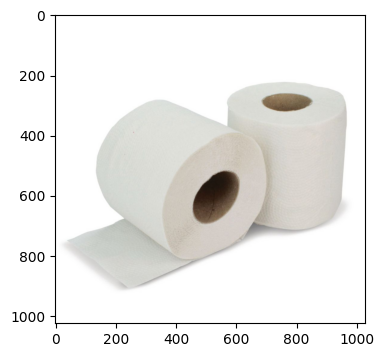

In [5]:
# determine the class given an output tensor, shape [1000]
def get_category(output):
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probability = torch.nn.functional.softmax(output, dim=0)
    prob = list(probability.numpy())
    idx = prob.index(max(prob))
    return idx

# -- load an image and apply Resnet 18 on this image
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
USE_CUDA = False
device = torch.device('cuda:1' if USE_CUDA else 'cpu')
input_batch = input_batch.to(device)
res18 = res18.to(device)

time0 = time()
with torch.no_grad():
    output = res18(input_batch)
time1 = time()
print('time elasped', time1 - time0, 'sec')
    
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output.shape)
c = get_category(output[0])
print(inet[c])

plt.figure(figsize=(4,4))
plt.imshow(input_image)
plt.axis('equal')

In [7]:
# transfer learning
# feature extractor, using all laters from resnet-18 except for
# the last 2 layers
fe = nn.Sequential(*list(res18.children())[:-1])
output = fe(input_batch)
print(input_batch.shape, output.shape)
# print(res18)

torch.Size([1, 3, 224, 224]) torch.Size([1, 512, 1, 1])


In [6]:
# -- now ready for define classification and regression layer
import torch.nn.functional as F
import copy

class ResDet(nn.Module):
    def __init__(self):
        super(ResDet, self).__init__()
        self.fe = copy.deepcopy(nn.Sequential(*list(res18.children())[:-2]))
        self.fe.requires_grad = False
        for p in self.fe.parameters():
            p.requires_grad = False
        # 
        # self.cat = nn.Conv2d(512, 21, 1, 1) # 512 channels => 21 channels

        # -- classification
        self.cat = nn.Linear(512 * 7 * 7, 21) # 512 channels => 21 channels

        # -- regression
        self.reg = nn.Sequential(
            nn.Dropout(0.5),
            nn.Flatten(1),
            nn.Linear(512*7*7, 1024),
            nn.ReLU(),
            # nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 4),
            nn.Sigmoid()
        )

    # xb is a bacth of x_i, i.e., x1, x2, .., xn
    def forward(self, input):
        x = self.fe(input)
        y = self.cat(torch.flatten(x, 1))
        z = self.reg(x);
        # x = torch.flatten(x, start_dim = 1)
        return y, z

rd = ResDet()
a, b = rd(input_batch)

print(input_batch.shape, a.shape, b.shape)
print('a =', a)
print('b =', b)

a = res18(input_batch)
print('c =', a.shape)

torch.Size([1, 3, 224, 224]) torch.Size([1, 21]) torch.Size([1, 4])
a = tensor([[-1.5763,  0.7370,  1.5106,  0.4806, -0.5526,  0.3963, -0.4029, -1.7731,
         -2.0460, -1.1229, -1.0545,  0.9665,  1.9887, -2.4843, -0.1629,  1.3289,
         -1.4672, -0.8090, -0.2311,  0.9056,  1.0660]],
       grad_fn=<AddmmBackward0>)
b = tensor([[0.6604, 0.7697, 0.6100, 0.5135]], grad_fn=<SigmoidBackward0>)
c = torch.Size([1, 1000])


In [7]:
# Pascal VOC data set
preprocess = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.VOCDetection('/workpy/labs/voc', 
    year = '2010', image_set = 'train', download = True, transform = preprocess)

print('train size =', len(trainset))

a = trainset[0]
print(a[0].shape)
print(a[1])

Using downloaded and verified file: /workpy/labs/voc\VOCtrainval_03-May-2010.tar
Extracting /workpy/labs/voc\VOCtrainval_03-May-2010.tar to /workpy/labs/voc
train size = 4998
torch.Size([3, 224, 224])
{'annotation': {'folder': 'VOC2010', 'filename': '2008_000008.jpg', 'source': {'database': 'The VOC2008 Database', 'annotation': 'PASCAL VOC2008', 'image': 'flickr'}, 'size': {'width': '500', 'height': '442', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'horse', 'pose': 'Left', 'truncated': '0', 'occluded': '1', 'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'}, 'difficult': '0'}, {'name': 'person', 'pose': 'Unspecified', 'truncated': '1', 'occluded': '0', 'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'}, 'difficult': '0'}]}}


In [8]:
# return all the names, bounding boxes,
# and the index of the major item (the one with
# the largest bounding box)
def get_annotation(a):
    sz = a['annotation']['size']
    width = float(sz['width'])
    height = float(sz['height'])
    
    lab = a['annotation']['object']
    names = []; borders = [];
    idx = 0; max_sz = 0
    cnt = 0
    for i in lab:
        names.append(i['name'])
        j = i['bndbox']
        x0 = float(j['xmin']) / width
        x1 = float(j['xmax']) / width
        y0 = float(j['ymin']) / height
        y1 = float(j['ymax']) / height
        borders.append([x0, y0, x1, y1])
        sz = (x1 - x0 + 1) * (y1 - y0 + 1)
        if sz > max_sz:
            max_sz = sz
            idx = cnt
        cnt+=1
    return names, borders, idx

# get the class index of a name
def get_index(cnames, name):
    return cnames.index(name);

# get all the names in the Pascal trainset
cname = open('/workpy/labs/voc/category.txt').read().split('\n')
print('names =', cname)
print('index of cat is', cname.index('cat'))

# convert the annotaion to three tensors
# => [images, labels, boxes]
def sample2tensors(samples):
    img_list = [i[0] for i in samples];
    lab_list = []; bbox_list = [];
    for i in samples:
        names, borders, idx = get_annotation(i[1]);
        lab = torch.tensor(get_index(cname, names[idx]), dtype=torch.int64)
        lab_list.append(lab)
        bd = torch.tensor(borders[idx])
        bbox_list.append(bd)
    images = torch.stack(img_list)
    labels = torch.stack(lab_list)
    bbox = torch.stack(bbox_list)
    return images, labels, bbox

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size = 32, shuffle = True, collate_fn = sample2tensors)


names = ['horse', 'cat', 'car', 'chair', 'motorbike', 'cow', 'bottle', 'pottedplant', 'tvmonitor', 'aeroplane', 'sofa', 'sheep', 'bus', 'boat', 'bird', 'dog', 'train', 'bicycle', 'person', 'diningtable']
index of cat is 1


In [9]:
def normalize_for_plot(a):
    c0 = a.min(); c1 = a.max()
    a = (a - c0) / (c1 - c0)
    return a.permute(1, 2, 0);

def plot_tensor(x, names = None, borders = None, ax = plt):
    a = normalize_for_plot(x)
    ax.imshow(a)
    if names is not None:
        h = a.shape[0]
        w = a.shape[1]
        for i in range(len(borders)):
            text = names[i]
            bd = borders[i]
            x0 = bd[0] * w; y0 = bd[1] * h;
            x1 = bd[2] * w; y1 = bd[3] * h;
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0])
            ax.text(x0 * 0.9 + x1 * 0.1, y0 * 0.9 + y1 * 0.1, text, color = 'red')
    
    ax.axis('equal')
    ax.axis('off')


{'width': '500', 'height': '327', 'depth': '3'} 
------
[{'name': 'bottle', 'pose': 'Unspecified', 'truncated': '1', 'occluded': '1', 'bndbox': {'xmin': '270', 'ymin': '1', 'xmax': '378', 'ymax': '176'}, 'difficult': '0'}, {'name': 'bottle', 'pose': 'Unspecified', 'truncated': '1', 'occluded': '1', 'bndbox': {'xmin': '57', 'ymin': '1', 'xmax': '164', 'ymax': '150'}, 'difficult': '0'}] 
------
bottle {'xmin': '270', 'ymin': '1', 'xmax': '378', 'ymax': '176'}
bottle {'xmin': '57', 'ymin': '1', 'xmax': '164', 'ymax': '150'}
bottle [0.54, 0.0030581039755351682, 0.756, 0.5382262996941896]
bottle [0.114, 0.0030581039755351682, 0.328, 0.45871559633027525]
largest =  0


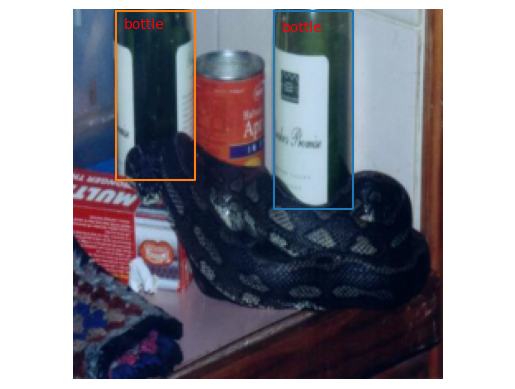

In [10]:
k = 1
a = trainset[k]
sz = a[1]['annotation']['size']
lab = a[1]['annotation']['object']
print(sz, '\n------')
print(lab, '\n------')
for i in lab:
    print(i['name'], i['bndbox'])

nm, roi, idx = get_annotation(a[1])
for i in range(len(roi)):
    print(nm[i], roi[i])
print('largest = ', idx)

plot_tensor(a[0], nm, roi)

tensor([[-88.9276, -12.7574, -23.5247, -52.9646,  35.9669, -94.3761, 191.4834,
          89.0961,  35.9469,   7.9138,  74.9024, -92.3355, -44.1593, -19.3539,
          31.6256,  41.5780,  68.8715,  39.2943, -71.7569, -61.9095, -46.1749]],
       grad_fn=<AddmmBackward0>) tensor([[0.2734, 0.0294, 0.8812, 0.7048]], grad_fn=<SigmoidBackward0>)
[array([0.27340728, 0.0293836 , 0.8811949 , 0.70484483], dtype=float32)]


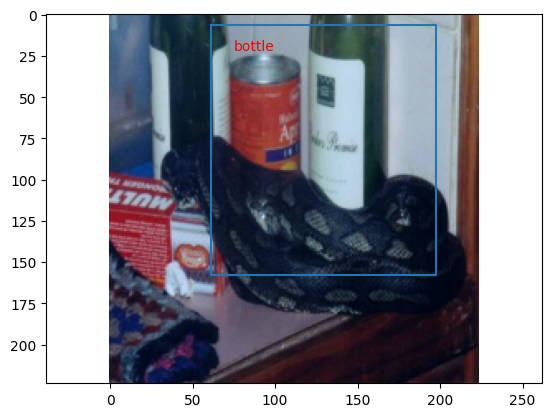

In [26]:
input_batch = a[0].unsqueeze(0)
p, q = rd(input_batch)
ps = p[0].tolist()
idx = ps.index(max(ps))
print(p, q)
bd = list(q.detach().numpy())
print(bd)
plot_tensor(input_batch[0], [cname[idx]], bd)

In [15]:
ig, lb, bb = next(iter(trainloader))
print(ig.shape, lb.shape, bb.shape)

print(lb)
print(bb)

torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 4])
tensor([12,  7,  9,  0, 19, 15,  4, 18,  4,  1])
tensor([[0.0120, 0.3147, 0.9780, 0.7307],
        [0.1200, 0.3491, 0.3420, 0.6331],
        [0.1560, 0.2420, 0.8880, 0.6406],
        [0.0540, 0.1496, 0.9060, 0.8892],
        [0.0028, 0.6140, 1.0000, 1.0000],
        [0.2560, 0.1200, 0.9540, 0.9973],
        [0.0030, 0.1960, 0.7545, 1.0000],
        [0.3280, 0.0027, 0.7620, 0.7307],
        [0.2580, 0.4615, 1.0000, 1.0000],
        [0.6040, 0.1760, 1.0000, 0.9173]])


In [20]:
# label = torch.tensor([cname.index(nm[idx])], dtype=torch.int64)
# print('label =', nm[idx], label, label.dtype)
# rd = ResDet()
rd = torch.load('voc/resdet.pt')
rd = rd.to('cpu')
images, labels, bbox = next(iter(trainloader))
p, q = rd(images)
print('p, q =', p.shape, q.shape)
print('labels = ', labels.shape)
print('images = ', images.shape)
# print('p = ', p)

# classficiation loss
criterion_cat = nn.CrossEntropyLoss()
loss = criterion_cat(p, labels) # calculate the NLL loss
print('loss_cat =', loss)

# regression loss
criterion_reg = nn.L1Loss()
loss = criterion_reg(q, bbox)
print('loss_reg =', loss)


p, q = torch.Size([32, 21]) torch.Size([32, 4])
labels =  torch.Size([32])
images =  torch.Size([32, 3, 224, 224])
loss_cat = tensor(0., grad_fn=<NllLossBackward0>)
loss_reg = tensor(0.0670, grad_fn=<MeanBackward0>)


In [ ]:
# training
USE_GPU = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if USE_GPU else "cpu")
print('Using', device)

rd = rd.to(device)
# opt_cat = optim.SGD(rd.cat.parameters(), lr = 0.003, momentum = 0.9)
# opt_reg = optim.SGD(rd.reg.parameters(), lr = 0.003, momentum = 0.9)
optimizer = optim.SGD(rd.parameters(), lr = 0.003, momentum = 0.9)

time0 = time()
num = len(trainloader)

for i in range(30):
    rloss_cat = 0
    rloss_reg = 0
    cnt = 0
    for images, labels, bbox in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        bbox = bbox.to(device)

        #  opt_cat.zero_grad()
        # opt_reg.zero_grad()
        optimizer.zero_grad();
        p, q = rd(images) #.to(device)
        
        # -- learning classification
        loss = criterion_cat(p, labels) # calculate the NLL loss
        loss.backward(retain_graph=True)
        optimizer.step()
        rloss_cat += loss.item()

        # -- learning regression
        loss = criterion_reg(q, bbox)
        loss.backward()
        optimizer.step()
        rloss_reg += loss.item()

        cnt += 1;
        if cnt % 20 == 0:
            print(rloss_cat /cnt, rloss_reg /cnt)
        
    print("Epoch {} - Training loss: {}, {}"
          .format(i, rloss_cat/num, rloss_reg/num))
    torch.save(rd, 'voc/resdet.pt' )
    
time1 = time()
print('time elapsed', time1 - time0, 'sec')

In [ ]:
valset = torchvision.datasets.VOCDetection('/workpy/labs/voc', 
    year = '2010', image_set = 'val', download = True, transform = preprocess)
valloader = torch.utils.data.DataLoader(
    valset, batch_size = 10, shuffle = True, collate_fn = sample2tensors)

In [ ]:
def compare_predict(sample, model, plot = False):
    if len(sample) == 2:
        nm, roi, idx = get_annotation(sample[1])
    else:
        roi = None; nm = None;
        
    b = sample[0].unsqueeze(0)
    with torch.no_grad:
        p, q = model(b)
    ps = p[0].tolist()
    ip = ps.index(max(ps))
    bd = list(q.detach().numpy())

    if plot:
        fig, ax = plt.subplots(1, 2)
        SZ = 4
        fig.set_figwidth(2 * SZ)
        fig.set_figheight(SZ)
        plot_tensor(sample[0], nm, roi, ax = ax[0])
        plot_tensor(b[0], [cname[ip]], bd, ax = ax[1])

    predict_cat = (cname[ip] == nm[idx])
    c1 = np.array(roi[idx])
    c2 = np.array(bd)
    predict_bbox = np.sum(abs(c1 - c2) / 4)
    return predict_cat, predict_bbox
    

True 0.040106767416000375


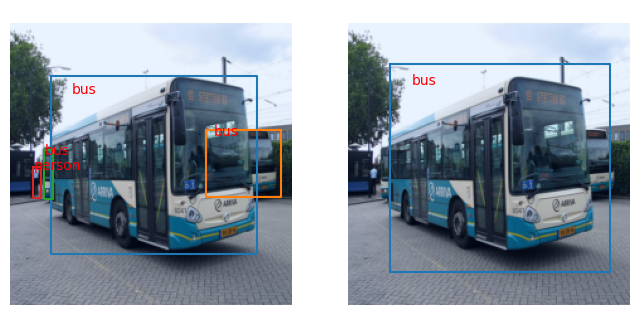

In [76]:
# td = rd.to(torch.device('cpu'))
k = 2565
a = valset[k]
p1, p2 = compare_predict(a, rd, plot = True)
print(p1, p2)

In [65]:
cnt = 0
misalign = 0
num = len(valset)

xd = rd #.to(device)
time0 = time()
for i in range(num):
    sample = valset[i]
    # [valset[i][0].to(device), valset[i][1]]
    p1, p2 = compare_predict(sample, xd, plot = False)
    if p1:
        cnt += 1;
    misalign += p2
    
    if i % 100 == 0:
        print('processed', i, '/', num) 

time1 = time();
print('Accuracy =', cnt / num, '; misalign =', misalign / num)
print('Time elapsed', time1 - time0, 'sec')

processed 0 / 5105
processed 50 / 5105
processed 100 / 5105
processed 150 / 5105
processed 200 / 5105
processed 250 / 5105
processed 300 / 5105
processed 350 / 5105
processed 400 / 5105
processed 450 / 5105
processed 500 / 5105
processed 550 / 5105
processed 600 / 5105
processed 650 / 5105
processed 700 / 5105
processed 750 / 5105
processed 800 / 5105
processed 850 / 5105
processed 900 / 5105
processed 950 / 5105
processed 1000 / 5105
processed 1050 / 5105
processed 1100 / 5105
processed 1150 / 5105
processed 1200 / 5105
processed 1250 / 5105
processed 1300 / 5105
processed 1350 / 5105
processed 1400 / 5105
processed 1450 / 5105
processed 1500 / 5105
processed 1550 / 5105
processed 1600 / 5105
processed 1650 / 5105
processed 1700 / 5105
processed 1750 / 5105
processed 1800 / 5105
processed 1850 / 5105
processed 1900 / 5105
processed 1950 / 5105
processed 2000 / 5105
processed 2050 / 5105
processed 2100 / 5105
processed 2150 / 5105
processed 2200 / 5105
processed 2250 / 5105
processed 2